In [38]:
# WordCloud & plotting
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Data handling
import numpy as np
import pandas as pd
from collections import Counter

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams, trigrams

# NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")

# Colormap
blue_gray_cmap = LinearSegmentedColormap.from_list(
    "blue_gray",
    ["#2d4ca3", "#8e8e8e"]
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/orincon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/orincon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/orincon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/orincon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/orincon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
# allowed pos
ALLOWED_POS = ("NN", "NNS", "NNP", "NNPS", "JJ", "JJR", "JJS")

# before lemmatization & normalization
df_stopwords = pd.read_csv("data/stop_words.csv")
CUSTOM_STOPWORDS = set(df_stopwords["word"].str.lower())

#after lemmatization & normalization
bad_words = {
    "accuracy surrogate",
    "accurate seismogram",
    "acoustic elastic",
    "artificial neural",
    "deep",
    "deep neural",
    "deep surrogate",
    "delta function",
    "descent",
    "difference",
    "difference finite",
    "elastic acoustic",
    "element",
    "finitedifference",
    "function",
    "helmholtz neural",
    "inversion acoustic",
    "inversion deep",
    "inversion geophysics",
    "learning",
    "learning geophysics",
    "learning inversion",
    "learning software",
    "marine salt",
    "migration geophysics",
    "network",
    "network adam",
    "network convolutional",
    "operator",
    "operator function",
    "operator neural",
    "operto",
    "salt",
    "surrogate reverse",
    "time",
    "time seismogram",
    "traveltime inversion",
    "dnn",
    "migration",
    "fourier pinn",
    "elastic waveform",
    "pinn fourier",
}

# Acronym & Term Normalization
ACRONYM_MAP = {

    # --- Neural networks & ML ---
    "pinn": "PINNs",
    "pinns": "PINNs",
    "convolutional network": "CNNs",
    "cnn": "CNNs",
    "cnns": "CNNs",
    "rnn": "RNNs",
    "network rnn": "RNNs",
    "rnns": "RNNs",
    "mlp": "MLP",
    "mlps": "MLP",
    "gan": "GANs",
    "gans": "GANs",
    "lstm": "LSTM",
    "unet": "U-Net",
    "swinet": "SWINet",
    "pinnslope": "PINNslope",
    "operator fno": "FNO",
    "difference fno": "FNO",
    "cnn migration": "CNNs",
    "fcn": "FCN",

    # --- Numerical methods ---
    "fem": "FEM",
    "fems": "FEM",
    "fd": "FDM",
    "fds": "FDM",
    "fdm": "FDM",
    "fdms": "FDM",
    "bem": "BEM",
    "bems": "BEM",
    "sem": "SEM",
    "spectral element": "SEM",

    # --- PDE / Physics ---
    "pde": "PDEs",
    "pdes": "PDEs",
    "helmholtz": "Helmholtz",
    "eikonal": "Eikonal",
    "ricker": "Ricker",
    "pml": "PML",

    # --- Inversion & Imaging ---
    "fwi": "FWI",
    "fwis": "FWI",
    "inversion fwi": "FWI",
    "reverse time": "RTM",
    "time migration": "RTM",
    "waveform inversion": "FWI",
    "tomogram": "tomography",

    # --- Optimization ---
    "adam": "Adam",
    "adam optimizer": "Adam",
    "bfgs": "BFGS",
    "stochastic descent": "SGD",

    # --- Software / Hardware ---
    "cpu": "CPU",
    "gpu": "GPU",
    "gpus": "GPU",
    "pytorch": "PyTorch",
    "sciml": "SciML",

    # --- Neural operators & models ---
    "fno": "FNO",
    "fnos": "FNO",
    "fga": "FGA",
    "wavenet": "WaveNet",
    "wavenet network": "WaveNet",
    "convolutional neural": "convolutional",
    "convolutional network": "convolutional",
    "recurrent neural": "recurrent",
    "autoencoder network": "autoencoder",
    "decoder network": "decoder",
    "decoder deep": "decoder",
    "adversarial network": "adversarial",
    "network universal": "universal approximator",

    # --- Math / signal processing ---
    "fourier": "Fourier",
    "fourier neural": "Fourier",
    "monte carlo": "Monte Carlo",
    "relu": "ReLU",
    "relu function": "ReLU",

    # --- Geophysics terms ---
    "pore": "porosity",
    "porous": "porosity",
    "prospecting": "prospection",

    # --- Misc ---
    "rmse": "RMSE",
    "ill": "ill-posed",
    "accurate": "accuracy",
    "arrival time": "arrival",
    "time surrogate": "surrogate",
    "time waveform": "waveform",
    "elastic waveform": "elastic",
    "traveltime": "travel time",
}


In [40]:
# Load text
def load_text(path):
    chunks = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            chunks.append(line.lower())
    return "".join(chunks)

def remove_consecutive_duplicates(tokens):
    return [t for i, t in enumerate(tokens) if i == 0 or t != tokens[i-1]]

In [41]:
text = load_text("data/text.txt")

In [42]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update(CUSTOM_STOPWORDS)

In [43]:
# TEXT CLEANING
text_ = text.lower()

# remove numbers
text_ = re.sub(r"\d+", " ", text_)


# keep hyphens to avoid splitting scientific terms
text_ = re.sub(r"[^\w\s-]", " ", text_)

# normalize hyphens
text_ = re.sub(r"-+", " ", text_)


text_ = re.sub(r"\b(\w+)\s+\1\b", r"\1", text_)

# tokenize
tokens = word_tokenize(text_)

# PROTECT MULTI-WORD EXPRESSIONS (BI + TRI GRAMS)
token_bigrams = list(bigrams(tokens))
token_trigrams = list(trigrams(tokens))

 # POS TAGGING + FILTERING
pos_tags = nltk.pos_tag(tokens)

filtered_tokens = []

for word, pos in pos_tags:

    if pos not in ALLOWED_POS:
        continue

    if not word.isalpha():
        continue

    lemma = lemmatizer.lemmatize(word.lower())

 
    # remove short tokens
    if len(lemma) <= 2:
        continue

    # skip stopwords
    if lemma in stop_words:
        continue

    filtered_tokens.append(lemma)
 
filtered_tokens = remove_consecutive_duplicates(filtered_tokens)
word_counts = Counter(filtered_tokens)
clean_text = " ".join(filtered_tokens)
clean_text = clean_text.replace("network neural", "")

with open("data/clean_text.txt", "w", encoding="utf-8") as f:
    f.write(clean_text)

In [49]:
wc = WordCloud(
    font_path="Montserrat-SemiBold.ttf",
    background_color="white",
    colormap=blue_gray_cmap,
    prefer_horizontal=0.8,
    max_words=150,
    width=5000,
    height=int(5000*0.40),
    random_state=1,
    min_font_size=50,
    max_font_size=270,
    margin=50,
    relative_scaling=0
)

wc.generate(clean_text)

In [50]:
filtered = {}

for w, f in wc.words_.items():
    if w in bad_words:
        continue

    key = ACRONYM_MAP.get(w.lower(), w)
    filtered[key] = filtered.get(key, 0) + f

wc.generate_from_frequencies(filtered)

df_wc = pd.DataFrame(
    wc.words_.keys(),
    columns=["word"]
)

df_wc.to_csv("data/wordcloud_words.csv", index=False)

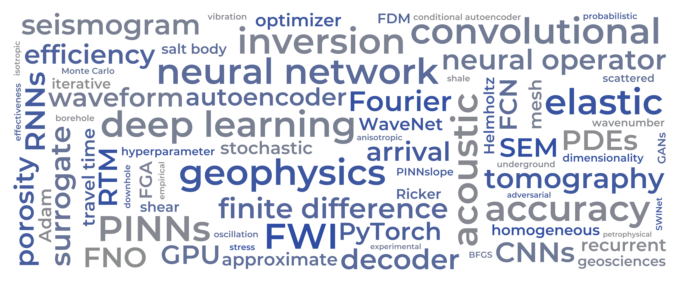

In [51]:
plt.figure(figsize=(6.8, (6.8*0.40)), constrained_layout=True)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("figs/wordcloud.svg", dpi=300)
plt.savefig("figs/wordcloud.pdf", dpi=300)
plt.show()
 